In [1]:
#%load_ext tensorboard
import os
import sys
sys.path.append(f"{os.environ['base']}Tools")

import btk
import datetime
import dataset_generators as dgen
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image, ImageDraw
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use(f"{os.environ['style']}")

In [ ]:
#Demo
tsx, tsy = dgen.character_spaces(3, dgen.trainfonts)
preds = tseg.predict(tsx)

for i, x in enumerate(tsx):
    display(Image.fromarray(x))
    if preds[0][0] > 0.7:
        display(1)
    else:
        display(0)
    display(tsy[i])

In [2]:
trainx, trainy, valx, valy = btk.depickler('trainx-1643716860', 'trainy-1643716860', 'valx-1643716860', 'valy-1643716860', 'ocr')

""" trainx, trainy = dgen.character_spaces(30000, dgen.trainfonts)
valx, valy = dgen.character_spaces(10000, dgen.evalfonts)
btk.pickle_set(trainx, trainy, valx, valy, 'ocr') """


""" trainx, valx = btk.standardize(trainx), btk.standardize(valx)
train = btk.DataGen(trainx, trainy, batch_len=1)
val = btk.DataGen(valx, valy, batch_len=1)
tdata = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True)
vdata = torch.utils.data.DataLoader(val, batch_size=256, shuffle=True) """

' trainx, valx = btk.standardize(trainx), btk.standardize(valx)\ntrain = btk.DataGen(trainx, trainy, batch_len=1)\nval = btk.DataGen(valx, valy, batch_len=1)\ntdata = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True)\nvdata = torch.utils.data.DataLoader(val, batch_size=256, shuffle=True) '

In [ ]:
imgent = btk.DataGen(trainx, trainy, 256)
imgenv = btk.DataGen(valx, valy, 64)


opti = keras.optimizers.Adam(learning_rate=0.001)
log_dir = "tblogs/segmentation/keras_test/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tbcall = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
estop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=16, restore_best_weights=True)


inp = keras.Input(shape=(32, 12, 1))
x = layers.Rescaling(1.0/255)(inp)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.08)(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.08)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = layers.Dropout(0.32)(x)
outp = layers.Dense(1, activation='sigmoid')(x)


tseg = keras.Model(inp, outp, name='tseg')
tseg.compile(
    optimizer=opti,
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history = tseg.fit(
    x = imgent,
    validation_data=imgenv,
    epochs=64,
    steps_per_epoch=24,
    validation_steps=24,
    callbacks=[estop],
    verbose=0
)

hist = pd.DataFrame(history.history)
hist[['accuracy', 'val_accuracy']].plot()
display(hist['val_accuracy'].max())
display(hist['val_loss'].min())


In [9]:
tseg = tf.keras.models.load_model('models\\tseg')
#tseg.save('models\\tseg')
#tseg.summary()

In [51]:
tseg = tf.keras.models.load_model('models\\tseg')

def draw_sep(img, seps):
    ymax = img.size[1]
    for x in seps:
        ImageDraw.Draw(img).line([x, 0, x, ymax], 0, 1)
    return img

def sp_predict(slices, sens):
    preds = [x[0] for x in tseg.predict(slices)]
    for i, x in enumerate(preds):
        if x <= sens:
            preds[i] = 0
    return preds

def row_detect(img, sdims):
    img = np.array(img).T
    #Extract vertical columns from the original image
    cols = [Image.fromarray(img[round(img.shape[0] * 0.25) - sdims[0]:round(img.shape[0] * 0.25)]),
            Image.fromarray(img[round(img.shape[0] * 0.50) - sdims[0]:round(img.shape[0] * 0.50)]),
            Image.fromarray(img[round(img.shape[0] * 0.75) - sdims[0]:round(img.shape[0] * 0.75)])]
    preds = []
    for y in cols:
        imslices = btk.img_slicer(y, sdims, 1, 'v')[0]
        preds.append(sp_predict(imslices, 0.5))
    preds = np.array(preds)
    preds = preds[0] + preds[1] + preds[2]  #space detection based on multiple regions
    preds[preds < 1] = 0
    zstart = 0
    zsections = []
    for i, x in enumerate(preds):
        if i == 0 or i == len(preds) - 1:
            pass
        if preds[i - 1] == 0 and x > 0: #start tracking edge region, indicates text border
            zstart = i
        if preds[i - 1] > 0 and x == 0: #leaving text border region
            zend = i
            if zend - zstart > 3:   #Text borders will generally be more than 3 pixels
                zsections.append((zstart, zend))  #add border region coords, text will be between two borders
    border = round(sum([x[1] - x[0] for x in zsections]) / len(zsections) / 2)
    zsections = [(x[1] - border, zsections[i + 1][1] + border) for i, x in enumerate(zsections) if i != len(zsections) - 1]
    rows = [img.T[x[0]:x[1]] for x in zsections]
    return rows

def split_letters(img, dims, sens):
    slices, idx = btk.img_slicer(img, dims, 1, 'v')
    preds = np.array(sp_predict(slices, sens))
    img = btk.force_dim(img, dims[0], 1)
    crits = btk.criticals(btk.smooth_avg(btk.smooth_avg(preds)), idx)
    crits = [int(btk.halfpoint(x[0][0], x[0][1])) for x in crits if x[1] == 'max']
    draw_sep(img, crits)
    display(img.resize((img.size[0] * 2, img.size[1] * 2)))
    #display(crits)
    return chopper(img, crits)

def chopper(img, divs):
    img = np.array(img)
    if divs[-1] - len(divs) >= 32:
        divs.append(divs[-1] + 32)
    else:
        divs.append(len(img[0]) - 1)
    cpack = []
    for i, x in enumerate(divs):
        if i == len(divs) - 1:
            break
        if divs[i + 1] - x >= 4:
            cpack.append(Image.fromarray(img[:, x:divs[i + 1]]))
    return cpack



(30, 370)

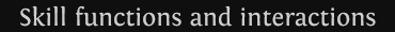

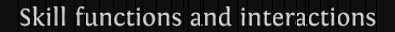

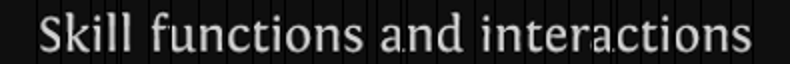

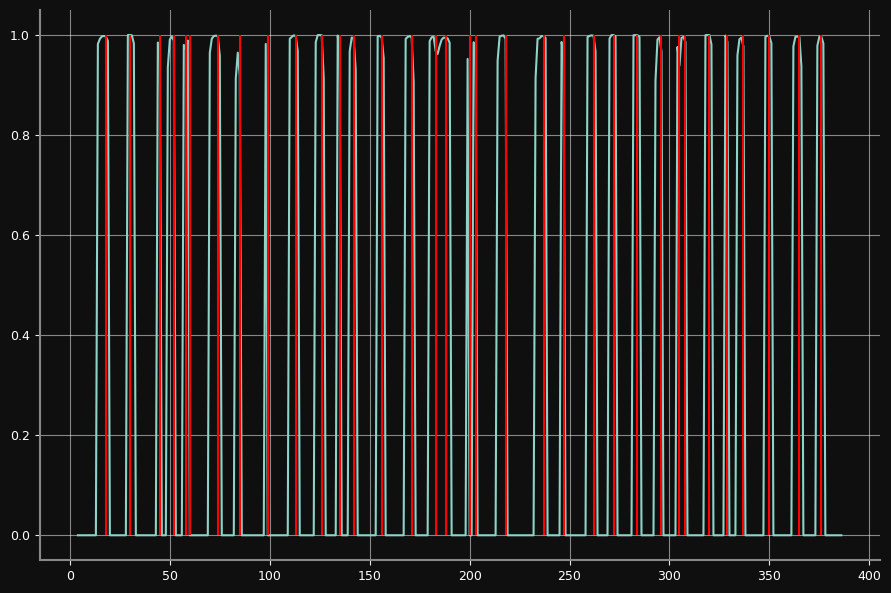

In [34]:
with Image.open("testimgs\\t16.png") as f:
    iar = btk.grey_np(f)[70:100, :370]
display(iar.shape)
im = Image.fromarray(iar).resize((395, 32))
display(im)


slices, idx = btk.img_slicer(im, (32, 12), 1, 'v')
preds = sp_predict(slices, 0.9)
#display(len(preds))
#display(preds)
crits = btk.criticals(preds, idx)
crits = [btk.halfpoint(x[0][0], x[0][1]) for x in crits if x[1] == 'max']
#display(crits)

draw_sep(im, crits)
display(im)
display(im.resize((790, 64)))

fig = plt.figure()
ax = plt.axes()
plt.plot(range(4, len(preds) + 4), preds)
plt.vlines(crits, 0, 1, colors='r')
plt.show()

(135, 345)

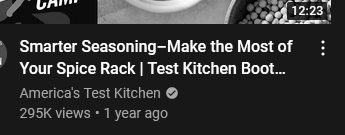

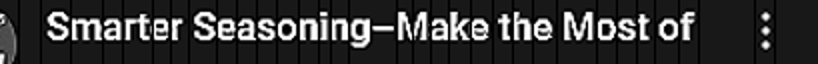

In [110]:
with Image.open("testimgs\\t14.png") as f:
    iar = btk.grey_np(f)[190:325, 425:770]
display(iar.shape)
im = Image.fromarray(iar)
display(im)

rows = row_detect(im, (32, 12))
#row = Image.fromarray(btk.sharpen(rows[3]))
row = Image.fromarray(btk.sharpen(rows[0]))

letters = split_letters(row, (32, 12), 0.75)
for x in letters:
    display(x)

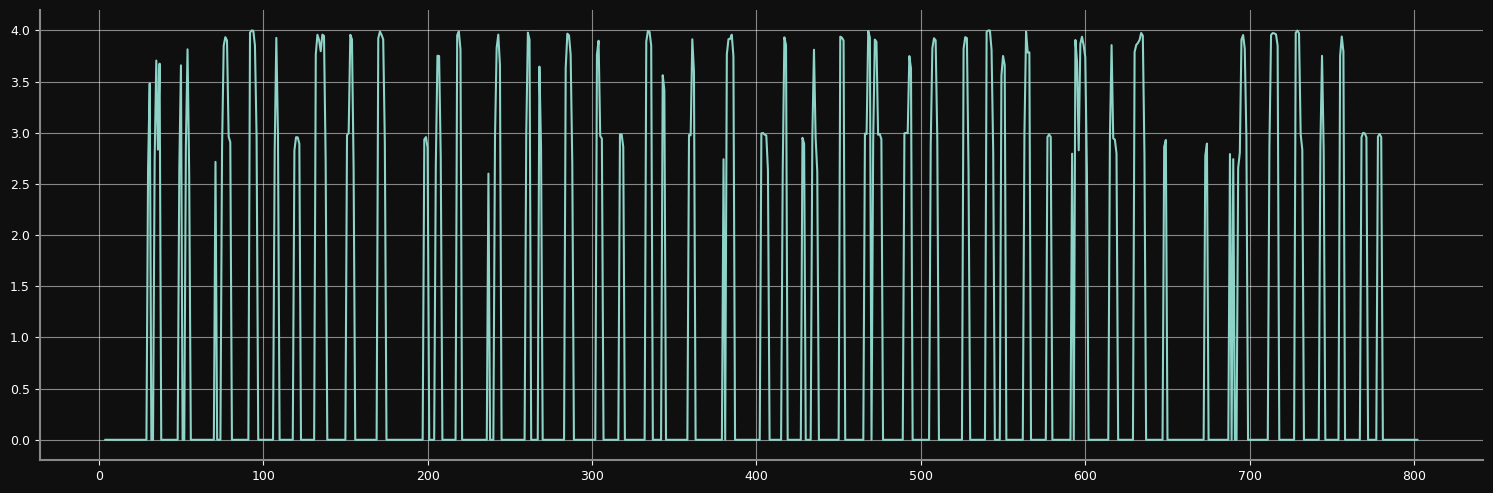

In [103]:
fig = plt.figure()
fig.set_size_inches(15, 5)
ax = plt.axes()
xax = range(4, len(total[0]) + 4)

plt.plot(xax, combined)
plt.show()

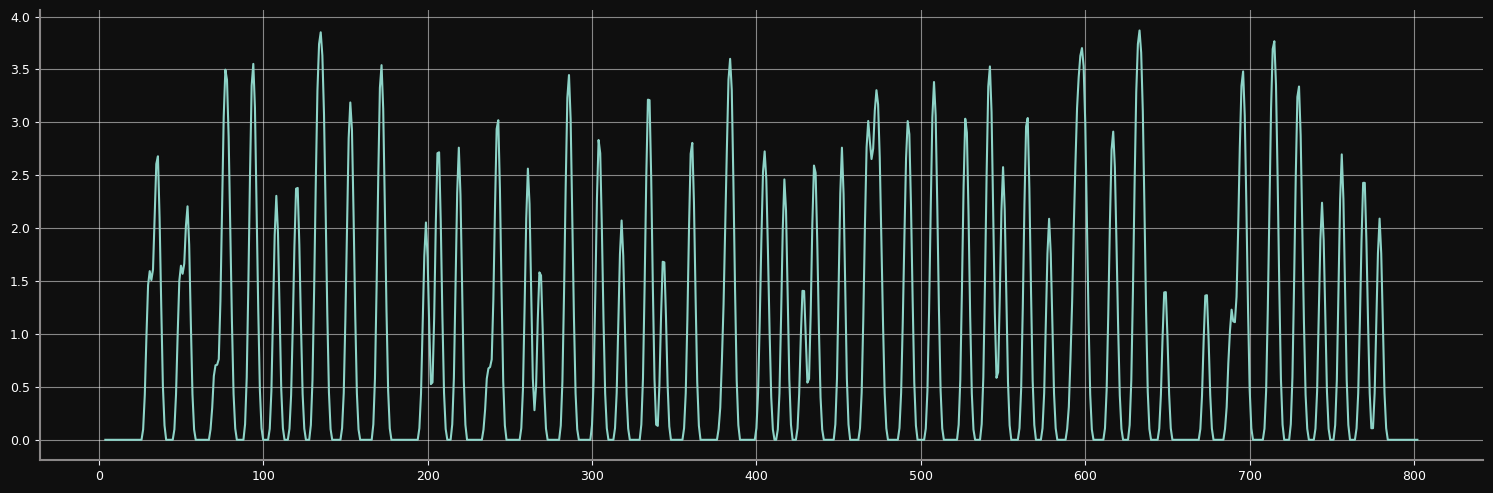

In [104]:
fig = plt.figure()
fig.set_size_inches(15, 5)
ax = plt.axes()

plt.plot(xax, btk.smooth_avg(btk.smooth_avg(btk.smooth_avg(combined))))
plt.show()

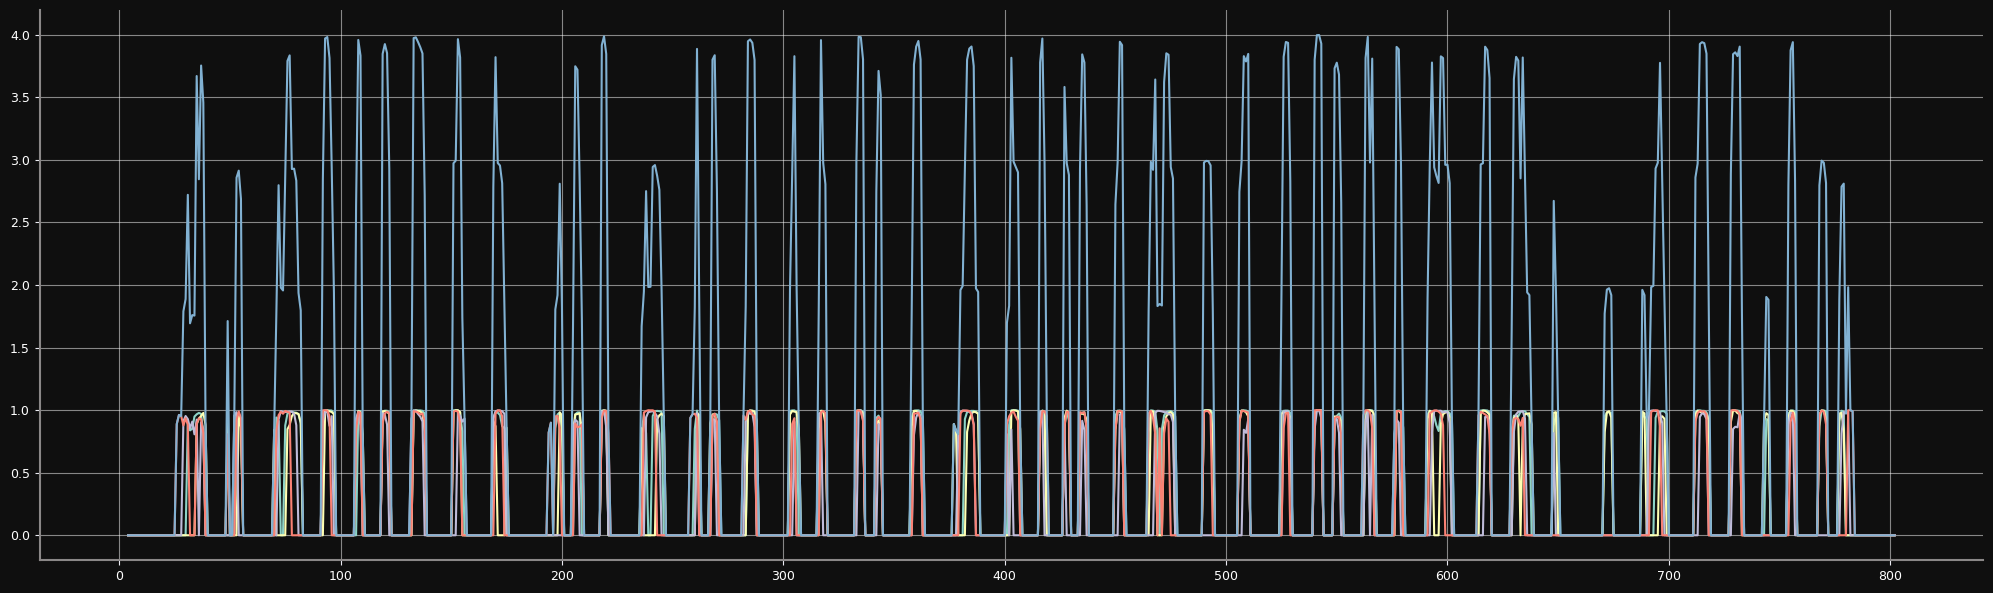

In [21]:
fig = plt.figure()
fig.set_size_inches(20, 6)
ax = plt.axes()
xax = range(4, len(total[0]) + 4)

combined = total[0] + total[1] + total[2] + total[3]

plt.plot(xax, total[0])
plt.plot(xax, total[1])
plt.plot(xax, total[2])
plt.plot(xax, total[3])
plt.plot(xax, combined)
plt.show()

(115, 431)

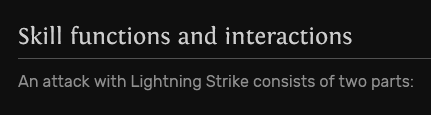

In [32]:
with Image.open("testimgs\\t16.png") as f:
    iar = btk.grey_np(f)[50:250, :]
display(iar.shape)
im = Image.fromarray(iar)
display(im)

rows = row_detect(im, (32, 12))
for x in rows:
    display(Image.fromarray(x))

(135, 345)

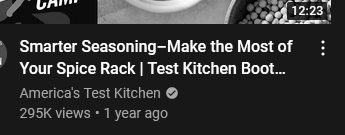

In [395]:
with Image.open("testimgs\\t14.png") as f:
    iar = btk.grey_np(f)[190:325, 425:770]
display(iar.shape)
im = Image.fromarray(iar)
display(im)

rows = row_detect(im, (32, 12))
for x in rows:
    display(Image.fromarray(x))

In [382]:
display(Image.fromarray(iar[24:37]))

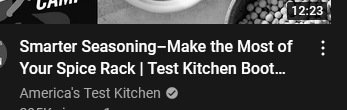

(347, 110)

" chars = chopper(find_spaces(im, 0.7))\n\nfor x in chars:\n    for y in x:\n        display(y)\n\nwith open(f'segtest2', 'ab') as pkf:\n    btk.pickle.dump(chars, pkf) "

In [270]:
with Image.open("testimgs\\t14.png") as f:
    iar = btk.grey_np(f)[190:300, 425:]
im = Image.fromarray(iar)
display(im)
display(im.size)

""" chars = chopper(find_spaces(im, 0.7))

for x in chars:
    for y in x:
        display(y)

with open(f'segtest2', 'ab') as pkf:
    btk.pickle.dump(chars, pkf) """

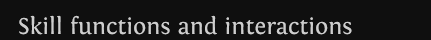

In [6]:
with Image.open("testimgs\\t16.png") as f:
    iar = btk.grey_np(f)[60:100, :]
im = Image.fromarray(iar)
display(im)

slices, idx = btk.img_slicer(im, (32, 12), 1, 'v')

test1 = sdetect(im, (32, 12), 0.7)

test2 = tseg.predict(slices)

In [7]:
tt = 99
display(test2[tt][0])
display(test1[0][tt])

0.3158613

0

(30, 370)

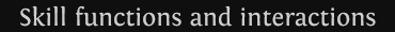

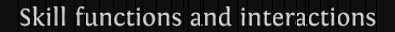

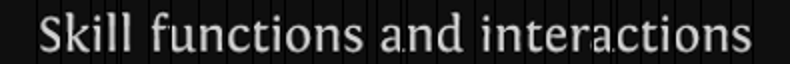

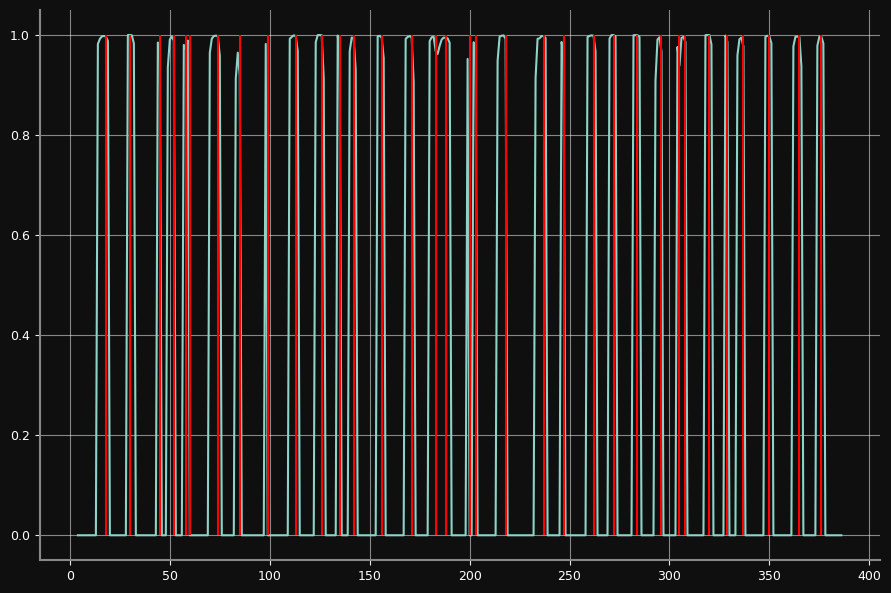

In [14]:
with Image.open("testimgs\\t16.png") as f:
    iar = btk.grey_np(f)[70:100, :370]
display(iar.shape)
im = Image.fromarray(iar).resize((395, 32))
display(im)

slices, idx = btk.img_slicer(im, (32, 12), 1, 'v')
preds = sp_predict(slices, 0.9)
#display(len(preds))
#display(preds)
crits = btk.criticals(preds, idx)
crits = [btk.halfpoint(x[0][0], x[0][1]) for x in crits if x[1] == 'max']
#display(crits)

draw_sep(im, crits)
display(im)
display(im.resize((790, 64)))

fig = plt.figure()
ax = plt.axes()
plt.plot(range(4, len(preds) + 4), preds)
plt.vlines(crits, 0, 1, colors='r')
plt.show()

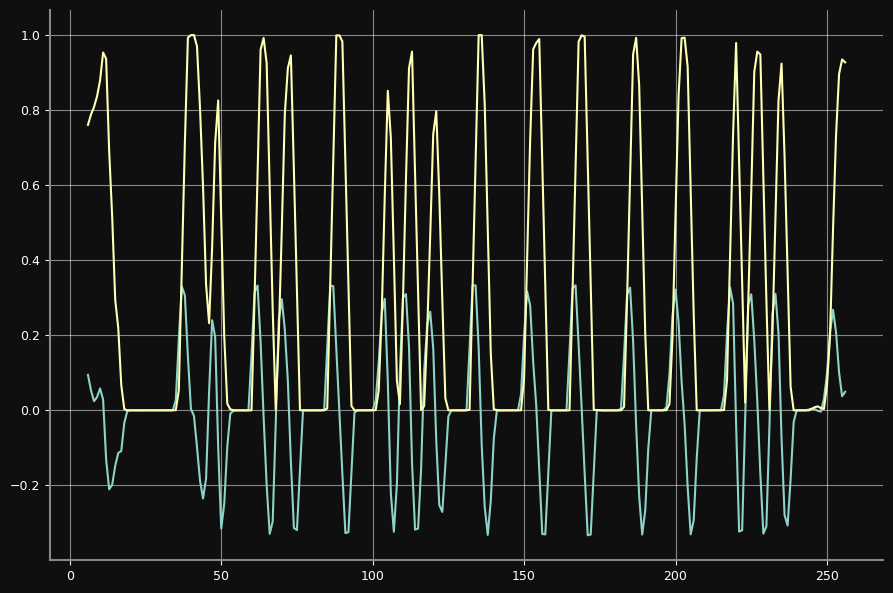

In [34]:
fig = plt.figure()
ax = plt.axes()
plt.plot(range(4, len(preds) + 4), preds)
plt.vlines(crits, 0, 1, colors='r')
plt.plot(btk.diff_compress(idx), btk.smooth_avg(np.gradient(grads)))
plt.plot(btk.diff_compress(idx), btk.smooth_avg(grads))
plt.plot(btk.diff_compress(idx), btk.smooth_avg(preds))
plt.show()
display(drawn.size)
display(drawn.resize((drawn.size[0] * 2, drawn.size[1] * 2)))